
# Автор: Серегин Михаил

**Отчет о проделанной работе**

**Признаки:**

*a) Признаки из t1_webstat, уникальыне для каждого действия*

Если order_id смержить с данными сессий, отсортировать по времени, то окажется следующее: 
1. Если есть разрыв в pageview_number, то вероятно, звонка не было, а это действие просто взято из t1_webstat. Поэтому добавим признак, характеризующий перерыв между соседними действиями, если был разрыв, иначе - NaN.
2. Судя по всему, page_type=1 отвечает за корзину, а page_type=3 скорее за ленту. Поэтому признак, отражающий тип предыдущей страницы важен.
3. Если действие последнее, то вероятнее, что это был звонок, особенно после page_type=1. Добавим признак, означающий время до последнего действия. 

*b)Признаки, полученные агрегацией по сессиям.*



*c) Таргет кодировка категориальных признаков (parent_id, root_id, utm_source, utm_medium).*

**Модель**

Использовался catboost с подбором параметров на сетке (параметры: количество деревьев, глубина, lr).





**Из интересного**

Второй бейзлайн можно было пробить с двумя признаками.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time

In [2]:
t1_webstat = pd.read_csv("t1_webstat.csv")

train = pd.read_csv("train.csv")

test = pd.read_csv("test.csv")

train["create_time"]=  pd.to_datetime(train.create_time)
train["model_create_time"] = pd.to_datetime(train.model_create_time)
test["create_time"]=  pd.to_datetime(test.create_time)
test["model_create_time"] = pd.to_datetime(test.model_create_time)
t1_webstat["date_time"] = pd.to_datetime(t1_webstat.date_time)

# Блок извлечения данных из t1webstat.


In [57]:
def surrounded(df):
    """
    gap is a parameter
    return 1 if True
    """

    ind = list(df.page_type==0).index(True)

    ln = len(df.iloc[ind-1:ind+2])
    if ln>2:
        return 1
    else:
        return 0

    return 

def last(df):
    """return 1 if True"""
    ind = list(df.page_type==0).index(True)

    if ind==0:
        return df.date_time.values[0] - df.date_time.values[1]
    else:
        return 0


def type_pred_page(df):

    ind = list(df.page_type==0).index(True)

    if len(df) == ind+1: # the last
        return np.NaN
    else:
        return df.at[ind+1,"page_type"]

def gap_pages(df):
    """
    если выполнено первое условие, то выяснить, есть ли разрыв в страницах. Приходим сюда только если выполнено условие
    if True, вероятно, что звонка не было. 
    """
    """return 1 if True"""


    ind = list(df.page_type==0).index(True)

    cur_df = df.iloc[ind-1:ind+2].copy()
    cur_df.drop(0,axis="index",inplace=True)
    vals=cur_df["pageview_number"].values
    if vals[0]-1==vals[1]:
        return 0
    else:
        return cur_df["date_time"].values[0] - cur_df["date_time"].values[1]

def start_of_time_seri(df):
    """ if True, return is the distance to the nearest report"""
    ind = list(df.page_type==0).index(True)
    if ind+1==len(df):
        return 1
    else:
        return 0



def agr(df_,order_id):
    """
    На вход: таблица со строкой, для которой нужно распарсить
    На выход: таблица-строка со значениями, скопированными и + признаки
    """

    df = df_.copy()
    sur = surrounded(df) # 1 or 0

    is_last = last(df)
    type_pred = type_pred_page(df)

    if sur:
        gap_number_pages = gap_pages(df)
    else:
        gap_number_pages = np.NaN

    is_start = start_of_time_seri(df)



    ind = list(df.page_type==0).index(True)
    if is_start:
        row = df.iloc[ind]
    else:

        row = df.iloc[ind+1]

    lst = list(row.values)
    lst.append(sur)
    lst.append(is_last)
    lst.append(type_pred)
    lst.append(gap_number_pages)
    lst.append(is_start)
    lst.append(order_id)

    return lst

In [58]:
import tqdm
def from_t1webstat_extract_data(dataframe):
    
    

    extract_df = pd.DataFrame([],columns=['sessionkey_id', 'date_time', 'page_type', 'pageview_number',
           'pageview_duration_sec', 'category_id', 'model_id', 'good_id', 'price',
           'product_in_sale',"surrounded","is_last","type_pred","gap_number_pages","is_start","order_id"])
    
    
    for session in tqdm.tqdm(dataframe.sessionkey_id.unique()):
        row_train = dataframe[dataframe.sessionkey_id==session].copy()
        logs =t1_webstat[t1_webstat.sessionkey_id==session].sort_values(by="date_time",ascending=False).copy()
        
        if len(logs)==0:
            continue




        for i in range(len(row_train)):
            logs.index=range(len(logs))
            necessary_data = row_train[["create_time","sessionkey_id","order_id"]].iloc[i].values
            new_data = [0 for i in range(10)]
            new_data[0] = necessary_data[1]
            new_data[1] = necessary_data[0]
            logs.loc[-1] = new_data
            logs.index = logs.index + 1
            logs = logs.sort_values(by="date_time",ascending=False)

            ## для каждой строки отдельно запускаем функцию, которая возвращает строку (которую затем конкатенируем)

            extract_lst = agr(logs, order_id=necessary_data[2])

            extract_df.loc[-1] = extract_lst
            extract_df.index = extract_df.index+1


            logs.drop(0,axis="index",inplace=True)
            
            
    return extract_df

In [59]:
extract_df_test = from_t1webstat_extract_data(test)
extract_df_test.columns = [i+"_extract" for i in extract_df_test.columns]

100%|██████████| 16019/16019 [02:49<00:00, 94.47it/s] 


In [60]:
extract_df_train = from_t1webstat_extract_data(train)
extract_df_train.columns = [i+"_extract" for i in extract_df_train.columns]

100%|██████████| 96803/96803 [23:58<00:00, 67.30it/s] 


In [65]:
## save results

extract_df_test.to_csv("extract_test2.csv",index=0)
extract_df_train.to_csv("extract_train2.csv",index=0)

In [3]:
# loading
train_extract = pd.read_csv("extract_train2.csv")
test_extract = pd.read_csv("extract_test2.csv")



merged_train = pd.merge(
    train,
    train_extract,
    how="left",
    left_on="order_id",
    right_on="order_id_extract",
    left_index=False,
    right_index=False,
    sort=True,
    copy=True,
    indicator=False,
    validate=None,
)

merged_test = pd.merge(
    test,
    test_extract,
    how="left",
    left_on="order_id",
    right_on="order_id_extract",
    left_index=False,
    right_index=False,
    sort=True,
    copy=True,
    indicator=False,
    validate=None,
)

# Мержим признаки  

In [4]:
session_agg = pd.read_csv("aggregation_karm.csv")

In [5]:
merged_train = merged_train.merge(session_agg, how='left', on='sessionkey_id', sort=False)
merged_test = merged_test.merge(session_agg, how='left', on='sessionkey_id', sort=False)

# Формируем признак "разрыва". Далее в данных называется seconds.

1. Если гэп в данных был, значит признак равен времени разрыва. 
2. Если публикация действия последняя во временном ряду, указывается время до предыдущего
3. Иначе NaN

In [6]:
def find_s(data):
    try:
        arr=data.split()
        d=int(arr[0])*24*60*60 
        h,m,s = arr[2].split(":")
        final = d+int(h)*60*60 + int(m)*60+float(s)
    except:
        return 0
    return final

last_lst=merged_train["is_last_extract"].values
gap_lst=merged_train["gap_number_pages_extract"].values



new_lst = []
for i,g in enumerate(gap_lst):
    if type(g)==float:
        new_lst.append(last_lst[i])
    else:
        new_lst.append(g)



for i in range(len(new_lst)):
    if (new_lst[i]=='0')or(new_lst[i]==0):
        new_lst[i] = 0
        continue
    if type(new_lst[i])==float:
        new_lst[i]=0
    new_lst[i] = find_s(new_lst[i])
    
    

In [7]:
merged_train["seconds"] = np.array(new_lst)

In [8]:
last_lst=merged_test["is_last_extract"].values
gap_lst=merged_test["gap_number_pages_extract"].values



new_lst = []
for i,g in enumerate(gap_lst):
    if type(g)==float:
        new_lst.append(last_lst[i])
    else:
        new_lst.append(g)


for i in range(len(new_lst)):
    if (new_lst[i]=='0')or(new_lst[i]==0):
        new_lst[i] = 0
        continue
    if type(new_lst[i])==float:
        new_lst[i]=0
    new_lst[i] = find_s(new_lst[i])
    
    

In [9]:
merged_test["seconds"] = np.array(new_lst)

# Tuning

In [21]:
## features that are to be dropped (for train)
drop_lst=["is_callcenter","model_create_time","create_time",'date_time_extract',
                     'order_id',
'order_id_extract','sessionkey_id_extract','sessionkey_id_extract','good_id','good_id_extract',
                                                "root_id",'model_id'
                                                                 ,"price_extract",'category_id','parent_id','model_id_extract'
          ,'goods_qty', 'category_id_extract',"pics_qty","description_length",
         'is_moderated',]

# for test
lst_test=list(set(merged_test.columns).intersection(set(drop_lst)))

In [333]:
import random
from itertools import product
best_score = 0.973
for n_est, d, lr in tqdm.tqdm(list(product(range(200,280,10),[6,7],np.linspace(0.001,0.5,10)))):
    X_train, X_test, y_train, y_test = train_test_split(merged_train.drop(drop_lst, axis=1)[[
    'pageview_duration_sec_extract',"seconds","ends_nan","sec_diff",
    'product_in_sale_extract','utm_medium',"pageview_number_extract","cat_id_ratio",
    "root_id_ratio","utm_source_id_ratio",'last_page_type',]],
                                                            merged_train.is_callcenter,shuffle=True,test_size=0.25,random_state=0)



    cat = CatBoostClassifier(verbose=False,n_estimators=n_est,depth=d,learning_rate=lr)
    cat.fit(X_train, y_train)
    pred=cat.predict_proba(X_test)
    score=roc_auc_score(y_test,pred[:,1])
    if score>best_score:
        best_score=score
        print(score,f"{n_est,d,lr}")

  2%|▏         | 3/160 [00:05<04:37,  1.77s/it]

0.9730439425325184 (200, 6, 0.11188888888888888)



  2%|▎         | 4/160 [00:07<04:34,  1.76s/it]

0.9734511432511211 (200, 6, 0.16733333333333333)


  9%|▉         | 14/160 [00:25<04:37,  1.90s/it]

0.9734686422310243 (200, 7, 0.16733333333333333)


 34%|███▍      | 54/160 [01:43<03:43,  2.11s/it]

0.9734715080847973 (220, 7, 0.16733333333333333)


 40%|████      | 64/160 [02:04<03:13,  2.02s/it]

0.9735019385901525 (230, 6, 0.16733333333333333)


 52%|█████▎    | 84/160 [02:47<02:40,  2.12s/it]

0.9735274945852954 (240, 6, 0.16733333333333333)


100%|██████████| 160/160 [05:52<00:00,  2.21s/it]


# Prediction

In [ ]:
[[
    'pageview_duration_sec_extract',"seconds","ends_nan","sec_diff",
    'product_in_sale_extract','utm_medium',"pageview_number_extract","cat_id_ratio",
    "root_id_ratio","utm_source_id_ratio",'last_page_type',]]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(merged_train.drop(drop_lst, axis=1)[[
    'pageview_duration_sec_extract',"seconds","ends_nan","sec_diff",
    'product_in_sale_extract','utm_medium',"pageview_number_extract","cat_id_ratio",
    "root_id_ratio","utm_source_id_ratio",'last_page_type',]],
                                                        merged_train.is_callcenter,shuffle=True,test_size=0.25,random_state=0)



cat = CatBoostClassifier(verbose=False,n_estimators=240,depth=6,learning_rate=0.1673333)
cat.fit(X_train, y_train)
pred=cat.predict_proba(X_test)
roc_auc_score(y_test,pred[:,1])

0.9733596310387265

In [36]:
pred_test=cat.predict_proba(merged_test.drop(lst_test,axis=1)[[
    'pageview_duration_sec_extract',"seconds","ends_nan","sec_diff",
    'product_in_sale_extract','utm_medium',"pageview_number_extract","cat_id_ratio",
    "root_id_ratio","utm_source_id_ratio",'utm_medium_id_ratio','last_page_type',]])

In [37]:
merged_test["is_callcenter"] = pred_test[:,1]

In [38]:
merged_test[["order_id","is_callcenter"]].to_csv("submit_kagglelast0.csv",index=0)

In [39]:
inds=np.argsort(cat.feature_importances_)
vals=np.sort(cat.feature_importances_)
names=np.array(cat.feature_names_)[inds]

<AxesSubplot:>

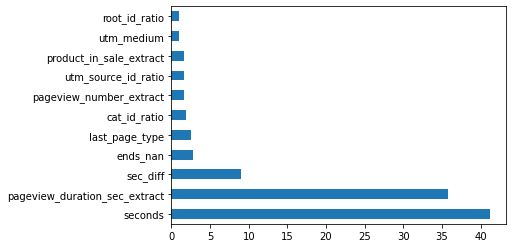

In [40]:
feat_importances = pd.Series(vals, index=names)
feat_importances.nlargest(20).plot(kind='barh')

# Target encoding of categorial features.

## category_id

In [10]:
seri1=merged_train.groupby(by="category_id").agg(
    summ=('is_callcenter', lambda x: np.sum(x)),
    countt=("is_callcenter",lambda x: len(x)))

seri1["ratio"] = seri1["summ"]/seri1["countt"]

ratio_cat_id = seri1[seri1.countt>50].sort_values(by="ratio")

cat_id_inds = ratio_cat_id.index

ratio_cat_id.countt.sum()

const = merged_train["is_callcenter"].sum() / merged_train["is_callcenter"].count()

def fill_category_id(data):
    if data not in cat_id_inds:
        return const
    elif data in cat_id_inds:
        return ratio_cat_id.loc[data]["ratio"]
    
    
merged_train["cat_id_ratio"] = merged_train["category_id"].apply(fill_category_id)
merged_test["cat_id_ratio"] = merged_test["category_id"].apply(fill_category_id)



## Parent_id

In [11]:
seri1=merged_train.groupby(by="parent_id").agg(
    summ=('is_callcenter', lambda x: np.sum(x)),
    countt=("is_callcenter",lambda x: len(x)))

In [12]:
seri1["ratio"] = seri1["summ"]/seri1["countt"]

ratio_cat_id = seri1[seri1.countt>200].sort_values(by="ratio")

cat_id_inds = ratio_cat_id.index

In [13]:
# считать не все, а те которые не попали???
const = merged_train["is_callcenter"].sum() / merged_train["is_callcenter"].count()

def fill_category_id(data):
    if data not in cat_id_inds:
        return const
    elif data in cat_id_inds:
        return ratio_cat_id.loc[data]["ratio"]
    
    
merged_train["parent_id_ratio"] = merged_train["parent_id"].apply(fill_category_id)
merged_test["parent_id_ratio"] = merged_test["parent_id"].apply(fill_category_id)

## root_id

In [14]:
seri1=merged_train.groupby(by="root_id").agg(
    summ=('is_callcenter', lambda x: np.sum(x)),
    countt=("is_callcenter",lambda x: len(x)))

seri1["ratio"] = seri1["summ"]/seri1["countt"]

ratio_cat_id = seri1[seri1.countt>30].sort_values(by="ratio")

cat_id_inds = ratio_cat_id.index

In [15]:
ratio_cat_id.countt.sum()

const = merged_train["is_callcenter"].sum() / merged_train["is_callcenter"].count()

def fill_category_id(data):
    if data not in cat_id_inds:
        return const
    elif data in cat_id_inds:
        return ratio_cat_id.loc[data]["ratio"]
    
    
merged_train["root_id_ratio"] = merged_train["root_id"].apply(fill_category_id)
merged_test["root_id_ratio"] = merged_test["root_id"].apply(fill_category_id)

## utm_source

In [16]:
seri1=merged_train.groupby(by="utm_source").agg(
    summ=('is_callcenter', lambda x: np.sum(x)),
    countt=("is_callcenter",lambda x: len(x)))

seri1["ratio"] = seri1["summ"]/seri1["countt"]

ratio_cat_id = seri1[seri1.countt>50].sort_values(by="ratio")

cat_id_inds = ratio_cat_id.index

In [17]:
const = merged_train["is_callcenter"].sum() / merged_train["is_callcenter"].count()

def fill_category_id(data):
    if data not in cat_id_inds:
        return const
    elif data in cat_id_inds:
        return ratio_cat_id.loc[data]["ratio"]
    
    
merged_train["utm_source_id_ratio"] = merged_train["utm_source"].apply(fill_category_id)
merged_test["utm_source_id_ratio"] = merged_test["utm_source"].apply(fill_category_id)

## utm_medium

In [18]:
seri1=merged_train.groupby(by='utm_medium').agg(
    summ=('is_callcenter', lambda x: np.sum(x)),
    countt=("is_callcenter",lambda x: len(x)))

seri1["ratio"] = seri1["summ"]/seri1["countt"]

ratio_cat_id = seri1[seri1.countt>50].sort_values(by="ratio")

cat_id_inds = ratio_cat_id.index

In [19]:
const = merged_train["is_callcenter"].sum() / merged_train["is_callcenter"].count()

def fill_category_id(data):
    if data not in cat_id_inds:
        return const
    elif data in cat_id_inds:
        return ratio_cat_id.loc[data]["ratio"]
    
    
merged_train["utm_medium_id_ratio"] = merged_train["utm_medium"].apply(fill_category_id)
merged_test["utm_medium_id_ratio"] = merged_test["utm_medium"].apply(fill_category_id)